In [7]:
# Packages
import pandas as pd
import math 
import numpy as np 
import seaborn as sns 
import os
import datetime as dt 
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm
import pickle
import matplotlib.cm as cm
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

## Model 

### Summary

We model the ROI's for an SP with 2 sectors following the introduction of the SDM Policy with slope $\frac{2}{7}$ within 4 different macroeconomic regimes 

1. FIL Conserved & Group Terminates
2. FIL Conserved & Group Does Not Terminate 
3. Data Conserved & Group Terminate 
4. Data Conserved & Group Does Not Terminate

We define the following: 
- $\textrm{T}$ be the event that the group collective decides to terminate 
- $\textrm{N}$ be the event that the group collectively decides not to termiante
- $\textrm{t}$ be the event that an individal sp decides to terminate
- $\textrm{n}$ be the event that an individual SP decides not to terminate
- $S$ - Salvage Value of a Sector
- $C$ - Reseal Cost of a Sector

We are interested in two ROI ratios for each conservation regime, and, ideally want the following conditions in the respective regimes

#### Termination Regime 
$$ \frac{ROI(\textrm{t|T})}{ROI(\textrm{n|T})} < 1 $$

#### Non-Termination Regime

$$ \frac{ROI(\textrm{t|N})}{ROI(n|N)} < 1 $$

where: 

$$ ROI(\textrm{t|T,N}) = \frac{E[BR_{terminate}] - (IP_{Reseal} - IP_{Seal}) - t_{fee} - C + S}{IP_{Reseal}} $$

and: 

$$ ROI(\textrm{n|T,N}) = \frac{E[BR_{noTermination}]}{IP_{Seal}} $$

Note: 
- $E[BR_{terminate}] = E[BR_{noTermination}]$ since the SP **maintains power** when she terminates and reonboards with the maximum SDM (2x) 
- $IP_{Seal}$ is the initial pledge required for sealing **2 sectors** 
- $IP_{Reseal}$ is the initial pledge required for sealing **1 sector** with a **2x SDM multiplier**


In [12]:
## Get Data
def get_regime_dfs(path=os.getcwd() + '/results/incentive_to_terminate/',
                  burn_boost='',
                  lock_target='',
                  plt_regime='',
                  duration_yr='', 
                  rbp_i= '',
                  rr_i= '',
                  filplus_i='',
                  duration_slope=0.285,
                  is140=True):
    group_terminate_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
    (burn_boost, lock_target, plt_regime, duration_yr, 'jump', str(rbp_i), 
     str(rr_i), str(filplus_i), duration_slope)
    group_terminate_key = 'SDM-(%s)' % (group_terminate_key,)
    
    group_no_terminate_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
    (burn_boost, lock_target, plt_regime, duration_yr, 'smooth', str(rbp_i), 
     str(rr_i), str(filplus_i), duration_slope)
    group_no_terminate_key = 'SDM-(%s)' % (group_no_terminate_key,)
    
    if is140:
        with open(path + 'duration_loop_results_terminationfee140days.pkl', 'rb') as f:
            results = pickle.load(f)
    else: 
        with open(path + 'duration_loop_results_terminationfee280days.pkl', 'rb') as f:
            results = pickle.load(f)


    dfs_dict = {}
    dfs_dict['Group_Terminates'] = results[group_terminate_key]
    dfs_dict['Group_No_Terminates'] = results[group_no_terminate_key]
    
    return dfs_dict
    

In [15]:
## Compute ROI Ratios for given regime

def compute_roi_ratios(dfs_dict_regime): 
    
    intervention_date = pd.to_datetime('2023-02-15')
    decision_date = intervention_date
    start_date = pd.to_datetime('2022-04-01')
    reward_years = 1
    end_date = decision_date + dt.timedelta(365 * reward_years)
    seal_date = start_date
    salvage_value = 1/3 * 0.2 
    reseal_cost = 0

    df = dfs_dict_regime['rbp_roi']
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)

    termination_mask = (df.index>=seal_date) & (df.index < decision_date)
    rewards_mask = (df.index>=seal_date) & (df.index < end_date)
    termination_cap = 5*140

    ROI_ratios = {}

    decision_dates = [intervention_date]
    months = 6
    for i in range(months): 
        decision_dates.append(decision_dates[-1] + dt.timedelta(30))

    results_roi_ratios = {}
    sdm_max = 2

    for idx,decision_date in enumerate(decision_dates):

        seal_date = start_date + dt.timedelta(30*idx)
        roi_ratios_dict = {}
        end_date = decision_date + dt.timedelta(365 * reward_years)
        termination_mask = (df.index>=seal_date) & (df.index < decision_date)
        rewards_mask = (df.index>=seal_date) & (df.index < end_date)
        #results_mask = (df.index>=start_date) & (df.index<decision_date)

        while seal_date < decision_date: 

            ## Compare ROI Ratios for keeping 2 sectors vs salvage value for 1 and then resealing max power (maintain power)
            IP_seal = sdm_max * df[df.index==seal_date]['day_pledge_per_QAP'].values
            IP_reseal = sdm_max * df[df.index==decision_date]['day_pledge_per_QAP'].values

            ## Calc ROI Terminate

            block_reward_terminate = sdm_max * df[rewards_mask]['day_rewards_per_sector'].values.sum()
            termination_fee = df[termination_mask]['day_rewards_per_sector'].head(termination_cap).values.sum()
            ROI_terminate = ((block_reward_terminate) - (IP_reseal - IP_seal) - termination_fee + salvage_value)/IP_reseal

            ## Calc ROI No Temrinate    
            block_reward_no_terminate = sdm_max * df[rewards_mask]['day_rewards_per_sector'].values.sum()
            ROI_no_terminate = block_reward_no_terminate/IP_seal

            ratio = float(ROI_terminate/ROI_no_terminate)

            roi_ratios_dict[seal_date] = ratio

            seal_date += dt.timedelta(1)

        roi_ratios_df = pd.DataFrame.from_dict(roi_ratios_dict, orient='index')
        roi_ratios_df.rename(columns={0: str(decision_date)}, inplace=True)
        #roi_ratios_df.columns = decision_date
        results_roi_ratios[decision_date] = roi_ratios_df
        
    return results_roi_ratios

### FIL Conserved Regime

In [17]:
burn_boost = 1
lock_target = 0.3 
plt_regime = 'fil_conserved'
duration_yr = 3
rbp_i = 'last_historical'
rr_i = rbp_i
filplus_i = 0.6
duration_slope = 0.285
dfs_dict_FIL_Conserved = get_regime_dfs(path=os.getcwd() + '/results/incentive_to_terminate/',
                  burn_boost=burn_boost,
                  lock_target=lock_target,
                  plt_regime=plt_regime,
                  duration_yr=duration_yr, 
                  rbp_i=rbp_i,
                  rr_i=rr_i,
                  filplus_i=filplus_i,
                  duration_slope=0.285,
                  is140=True)
    
results_roi_ratios_FIL_Conserved_group_terminates = compute_roi_ratios(dfs_dict_FIL_Conserved['Group_Terminates'])

results_roi_ratios_FIL_Conserved_group_no_terminates = compute_roi_ratios(dfs_dict_FIL_Conserved['Group_No_Terminates'])
    
    

Text(0.5, 0.98, 'Fil Conserved Regime')

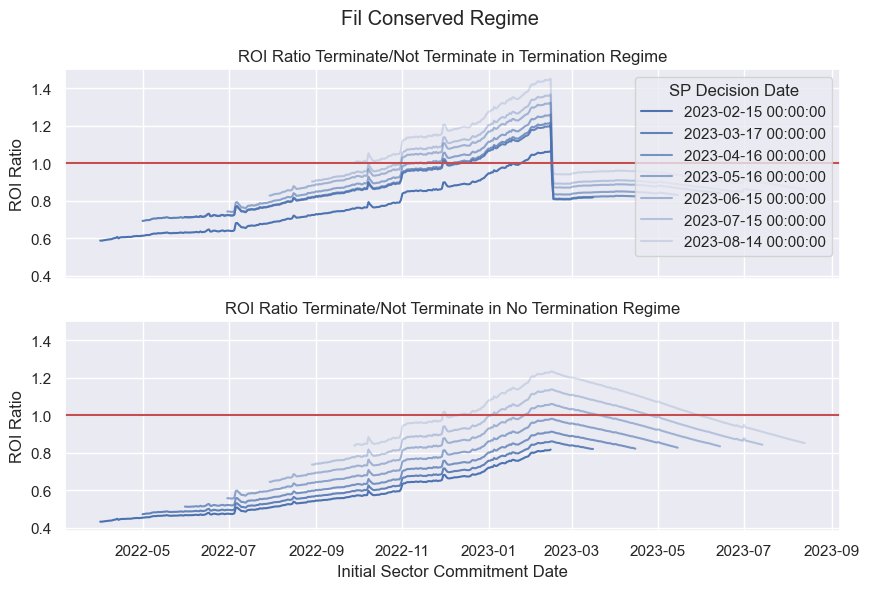

In [38]:
## Plot 
sns.set(rc = {'figure.figsize':(10,6)})

fig, axs = plt.subplots(2,1, sharey=True, sharex=True)

## Plot Results for Group Terminates 
results_roi_ratios = results_roi_ratios_FIL_Conserved_group_terminates
alphas = np.linspace(1,0.2,len(results_roi_ratios.keys()))
for idx,decision_date in enumerate(results_roi_ratios.keys()):
    sns.lineplot(data=results_roi_ratios[decision_date], alpha=alphas[idx],
                 label=decision_date, legend=False, ax=axs[0])
axs[0].axhline(1, c='r')
axs[0].set_title('ROI Ratio Terminate/Not Terminate in Termination Regime')
axs[0].legend(title='SP Decision Date')
axs[0].set_xlabel('Initial Sector Commitment Date')
axs[0].set_ylabel('ROI Ratio')

## Plot Results Group Does Not Terminate 

results_roi_ratios = results_roi_ratios_FIL_Conserved_group_no_terminates
alphas = np.linspace(1,0.2,len(results_roi_ratios.keys()))
for idx,decision_date in enumerate(results_roi_ratios.keys()):
    sns.lineplot(data=results_roi_ratios[decision_date], alpha=alphas[idx],
                 label=decision_date, legend=False, ax=axs[1])
axs[1].axhline(1, c='r')
axs[1].set_title('ROI Ratio Terminate/Not Terminate in No Termination Regime')
axs[1].set_xlabel('Initial Sector Commitment Date')
axs[1].set_ylabel('ROI Ratio')

plt.suptitle('Fil Conserved Regime')

### Data Conserved Regime 

In [33]:
burn_boost = 1
lock_target = 0.3 
plt_regime = 'data_conserved'
duration_yr = 3
rbp_i = 'last_historical'
rr_i = rbp_i
filplus_i = 0.6
duration_slope = 0.285
dfs_dict_Data_Conserved = get_regime_dfs(path=os.getcwd() + '/results/incentive_to_terminate/',
                  burn_boost=burn_boost,
                  lock_target=lock_target,
                  plt_regime=plt_regime,
                  duration_yr=duration_yr, 
                  rbp_i=rbp_i,
                  rr_i=rr_i,
                  filplus_i=filplus_i,
                  duration_slope=0.285,
                  is140=True)
    
results_roi_ratios_Data_Conserved_group_terminates = compute_roi_ratios(dfs_dict_Data_Conserved['Group_Terminates'])
results_roi_ratios_Data_Conserved_group_no_terminates = compute_roi_ratios(dfs_dict_Data_Conserved['Group_No_Terminates'])

Text(0.5, 0.98, 'Data Conserved Regime')

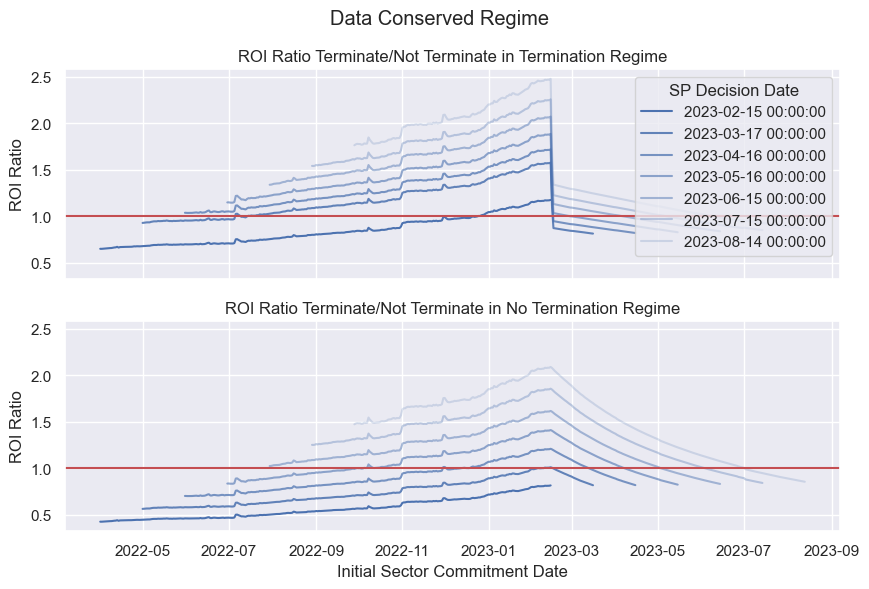

In [39]:
#Plot 
sns.set(rc = {'figure.figsize':(10,6)})

fig, axs = plt.subplots(2,1, sharey=True, sharex=True)

## Plot Results for Group Terminates 
results_roi_ratios = results_roi_ratios_Data_Conserved_group_terminates
alphas = np.linspace(1,0.2,len(results_roi_ratios.keys()))
for idx,decision_date in enumerate(results_roi_ratios.keys()):
    sns.lineplot(data=results_roi_ratios[decision_date], alpha=alphas[idx],
                 label=decision_date, legend=False, ax=axs[0])
axs[0].axhline(1, c='r')
axs[0].set_title('ROI Ratio Terminate/Not Terminate in Termination Regime')
axs[0].legend(title='SP Decision Date')
axs[0].set_xlabel('Initial Sector Commitment Date')
axs[0].set_ylabel('ROI Ratio')

## Plot Results Group Does Not Terminate 

results_roi_ratios = results_roi_ratios_Data_Conserved_group_no_terminates
alphas = np.linspace(1,0.2,len(results_roi_ratios.keys()))
for idx,decision_date in enumerate(results_roi_ratios.keys()):
    sns.lineplot(data=results_roi_ratios[decision_date], alpha=alphas[idx],
                 label=decision_date, legend=False, ax=axs[1])
axs[1].axhline(1, c='r')
axs[1].set_title('ROI Ratio Terminate/Not Terminate in No Termination Regime')
axs[1].set_xlabel('Initial Sector Commitment Date')
axs[1].set_ylabel('ROI Ratio')

plt.suptitle('Data Conserved Regime')